# **1. BASE CLASS** Shodor's Model

http://www.shodor.org/MASTER/environmental/general/energy/architecture.html

Its basic principle is that, for each timestep:

- temp[lat] = (self.R_in[lat] * (1 - albedo_step[lat]) + self.C * mean_temp - self.A) / (self.B + self.C)

- albedo_step[lat] = self.Aice if temp_step[lat] < self.Tcrit else self.Acloud


In [6]:
class EnergyBalanceModel:
    def __init__(self, A=204, B=2.17, C=3.87, Aice=0.62, Acloud=0.3, Tcrit=-10, SCfrac=1, SC=1370, iterations=30):
        self.A = A
        self.B = B
        self.C = C
        self.Aice = Aice
        self.Acloud = Acloud
        self.Tcrit = Tcrit
        self.SCfrac = SCfrac
        self.SC = SC
        self.iterations = iterations

        self.Zones = ["80-90", "70-80", "60-70", "50-60", "40-50", "30-40", "20-30", "10-20","0-10"]
        self.ZoneLat = [85, 75, 65, 55, 45, 35, 25, 15, 5]  
        self.ZoneSun = [0.5, 0.531, 0.624, 0.77, 0.892, 1.021, 1.12, 1.189, 1.219]
        self.Init_T = [-16.9, -12.3, -5.1, 2.2, 8.8, 16.2, 22.9, 26.1, 26.4]

        self.sumcos, self.coz = self.calculate_cosine_weighting()
        self.R_in = [self.SC / 4 * self.SCfrac * self.ZoneSun[lat] for lat in range(9)]

        self.Mean_T = []
        self.Albedo = []
        self.Temp = []

    def calculate_cosine_weighting(self):
        sumcos = 0
        coz = []
        for lat in range(9):
            coz_val = math.cos(self.ZoneLat[lat] * math.pi / 180)
            coz.append(coz_val)
            sumcos += coz_val
        return sumcos, coz

    def run_simulation(self):
        temp_step = self.Init_T[:]
        albedo_step = [(self.Aice if T < self.Tcrit else self.Acloud) for T in self.Init_T]
        self.Temp.append(temp_step[:])
        self.Albedo.append(albedo_step[:])

        for step in range(self.iterations + 1):
            Tcos = [temp * self.coz[lat] for lat, temp in enumerate(temp_step)]
            mean_temp = sum(Tcos) / self.sumcos
            self.Mean_T.append(mean_temp)

            for lat in range(9):
                temp_step[lat] = (self.R_in[lat] * (1 - albedo_step[lat]) + self.C * mean_temp - self.A) / (self.B + self.C)
                albedo_step[lat] = self.Aice if temp_step[lat] < self.Tcrit else self.Acloud

            self.Temp.append(temp_step[:])
            self.Albedo.append(albedo_step[:])

    def plot_global_mean_temperature(self):
        plt.figure()
        plt.plot(self.Mean_T, label="Global Mean Temperature", linestyle='-')
        plt.xlabel("Time Step")
        plt.ylabel("Temperature (°C)")
        plt.title("Global Mean Temperature over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_temperature_evolution(self, latitude_input):
        try:
            zone_index = self.ZoneLat.index(latitude_input)
        except ValueError:
            print(f"Latitude {latitude_input} not available. Please choose from {self.ZoneLat}")
            return

        temperature_series = [self.Temp[step][zone_index] for step in range(len(self.Temp))]

        plt.figure()
        plt.plot(range(len(temperature_series)), temperature_series, label=f"Temperature at {latitude_input}°", linestyle='-', color='orange')
        plt.xlabel("Time Step")
        plt.ylabel("Temperature (°C)")
        plt.title(f"Temperature Evolution at Latitude {latitude_input}°")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_albedo_evolution(self, latitude_input):
        try:
            zone_index = self.ZoneLat.index(latitude_input)
        except ValueError:
            print(f"Latitude {latitude_input}° not available. Please choose from {self.ZoneLat}")
            return

        albedo_series = [self.Albedo[step][zone_index] for step in range(len(self.Albedo))]

        plt.figure()
        plt.plot(range(len(albedo_series)), albedo_series, label=f"Albedo at {latitude_input}°", linestyle='-',
                 color='green')
        plt.xlabel("Time Step")
        plt.ylabel("Albedo")
        plt.title(f"Albedo Evolution at Latitude {latitude_input}°")
        plt.legend()
        plt.grid(True)
        plt.show()

# **2. INSOLATION-DRIVEN 1D EBM**

I create a subclass of the EnergyBalanceModel base class here - its a EBM model purely driven by insolation changes.

I only consider one hemispehre here because the annually-averaged insolation is symmetric between hemispheres.

In [7]:
import math
import matplotlib.pyplot as plt
import pandas as pd

In [48]:
class InsolationEBM(EnergyBalanceModel):
    def __init__(self, insolation_data, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.insolation_data = insolation_data
        self.iterations = len(insolation_data)

    def insolation_latitude(self, time_index):
        insolation_row = self.insolation_data.iloc[time_index]
        self.R_in = [
            insolation_row['Lat_85'],
            insolation_row['Lat_75'],
            insolation_row['Lat_65'],
            insolation_row['Lat_55'],
            insolation_row['Lat_45'],
            insolation_row['Lat_35'],
            insolation_row['Lat_25'],
            insolation_row['Lat_15'],
            insolation_row['Lat_5']
        ]

    def run_insolation_driven_simulation(self):
    #   iteration_count = 0  # Track the number of iterations
        for step in range(self.iterations):
            self.insolation_latitude(step)
            super().run_simulation()
    #       iteration_count += 1  
    #       print(f"Iteration {iteration_count} completed.")  
    #   print(f"Total iterations: {iteration_count}")

## **2.1 ORBITAL-SCALE 1D EBM:** Insolation-driven

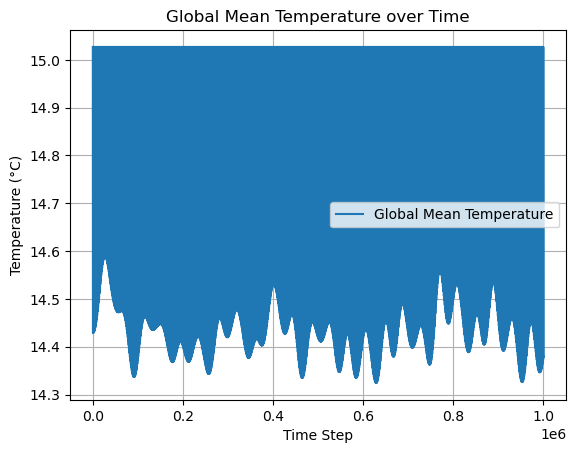

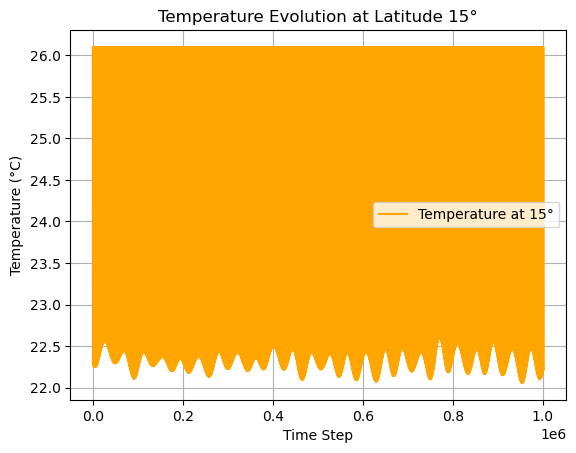

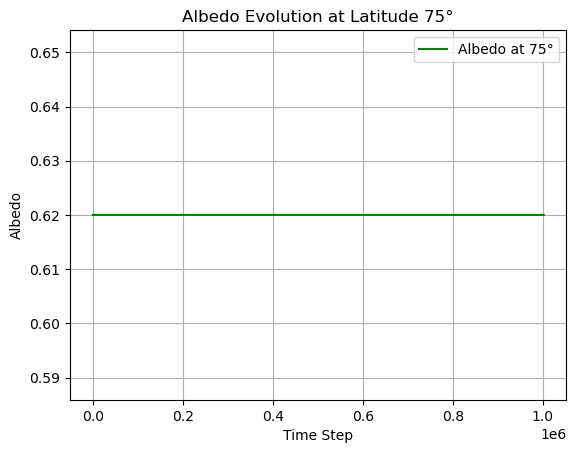

In [28]:
insolation_data = pd.read_excel(r"D:\OneDrive - University of Cambridge\Tripos\Projects\1D EBM\insolation_1000ka.xlsx")

insolation_model_1ma = InsolationEBM(insolation_data)
insolation_model_1ma.run_insolation_driven_simulation()
insolation_model_1ma.plot_global_mean_temperature()
insolation_model_1ma.plot_temperature_evolution(15)
insolation_model_1ma.plot_albedo_evolution(75)

## **2.2 HOLOCENE 1D EBM A:** Insolation-driven
I am still looking for proper latitudinal temperature data at the start of Holocene.

Here is a sample temperature distribution i generated using the second Legendre polynomial 𝑃2(𝑥):

In [29]:
import numpy as np

T_mean = 13.0                    # Mean global temperature at the start of the Holocene (°C)
Delta_T_eq_pole = 40.0           # Equator-to-pole temperature difference (°C)
Delta_T = Delta_T_eq_pole / 1.5  # Amplitude for the Legendre polynomial

latitudes = np.arange(5, 90, 10)

latitude_list = []
temperature_list = []

print("Latitude (°) | Temperature (°C)")
print("-------------------------------")

for phi in latitudes:
    phi_rad = np.radians(phi)
    x = np.sin(phi_rad)
    
    # Calculate the second Legendre polynomial P2(x) = (3x² - 1)/2
    P2 = (3 * x**2 - 1) / 2
    T_phi = T_mean + Delta_T * (-P2)
    
    latitude_list.append(phi)
    temperature_list.append(T_phi)
    
    print(f"     {phi:2.0f}       |      {T_phi:6.2f}")

Latitude (°) | Temperature (°C)
-------------------------------
      5       |       26.03
     15       |       23.65
     25       |       19.19
     35       |       13.17
     45       |        6.33
     55       |       -0.51
     65       |       -6.52
     75       |      -10.99
     85       |      -13.36


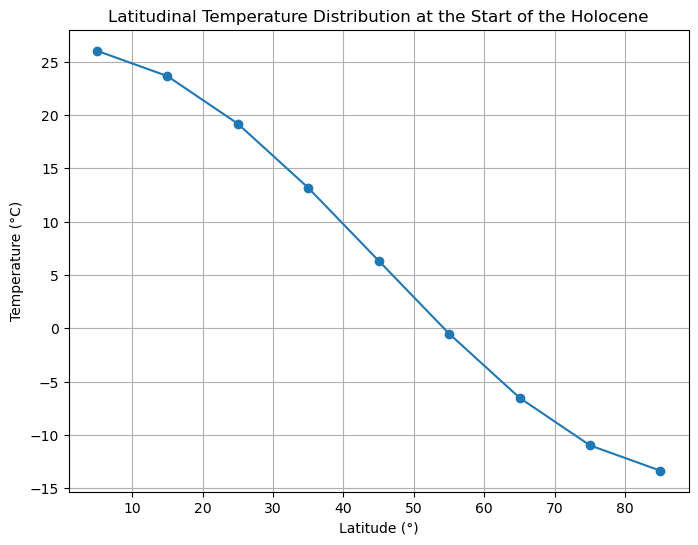

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(latitude_list, temperature_list, marker='o')
plt.title('Latitudinal Temperature Distribution at the Start of the Holocene')
plt.xlabel('Latitude (°)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

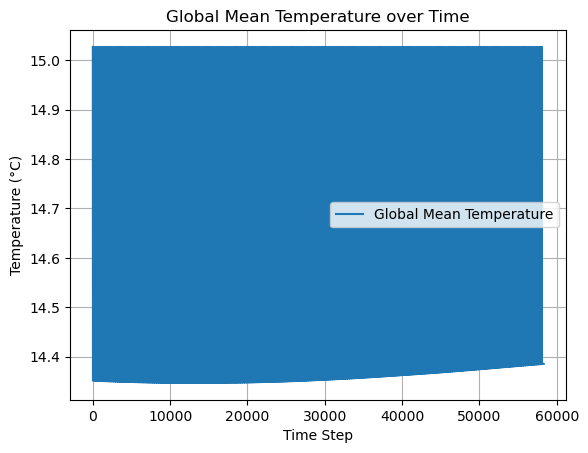

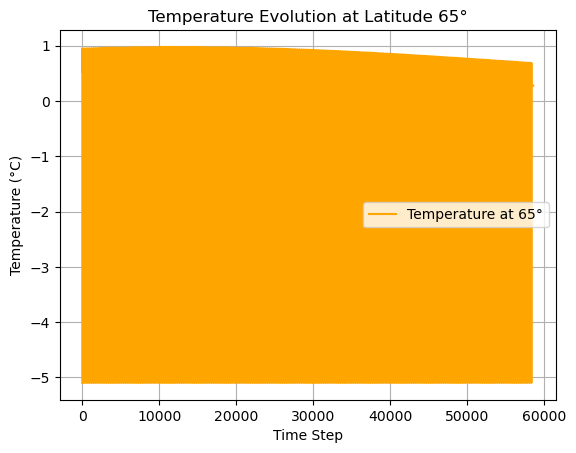

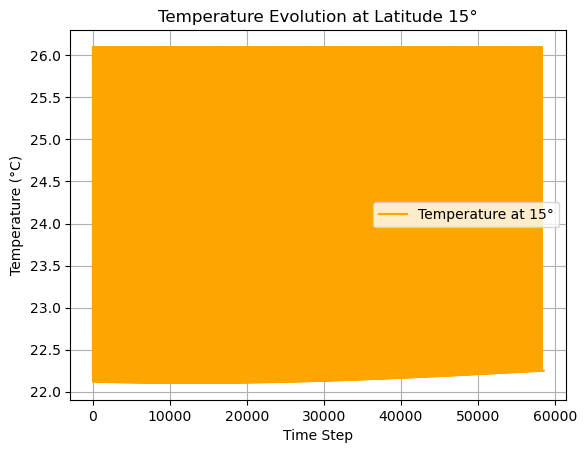

In [32]:
import pandas as pd
insolation_data = pd.read_csv(r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\Insolation_12kyr.csv")


insolation_model_12kyr = InsolationEBM(insolation_data)
insolation_model_12kyr.run_insolation_driven_simulation()
insolation_model_12kyr.plot_global_mean_temperature()
insolation_model_12kyr.plot_temperature_evolution(65)
insolation_model_12kyr.plot_temperature_evolution(15)

There is something wrong with the axis here, but I checked the times of iteration and it's correct. "60000" here corresponds to the current time period, as our model starts from 12000 bp.

As observed by the figures above, the insolation-driven self-iterating model can indeed simulate the increase in temperature during Holocene, despite that the amplitude is tiny. 

Notably, the trends at different latitudes are significantly dinstinctive from each other: higher latitudes are simulated to cool during the Holocene, while the low latitudes warm. This is the direct result of the increase in low latitude insolation and decrease in high latitude insolation during the Holocene period.

## **2.3 HOLOCENE 1D EBM B:**  with radiative forcings

- Orbital-driven insolation changes
- Ice cover driven RF (ICE-6G, assuming that albedo of ice = 0.7)
- Volcanic driven RF (use SOAD data from Sigl et al., 2022; RF = −25 · SAOD (Hansen et al., 2005))
- Greenhouse gas RF (Koehler et al., 2017)


**A New Way of Calculating Temperature** (This formula is written by myself, and I am not sure whether it is correct or not)

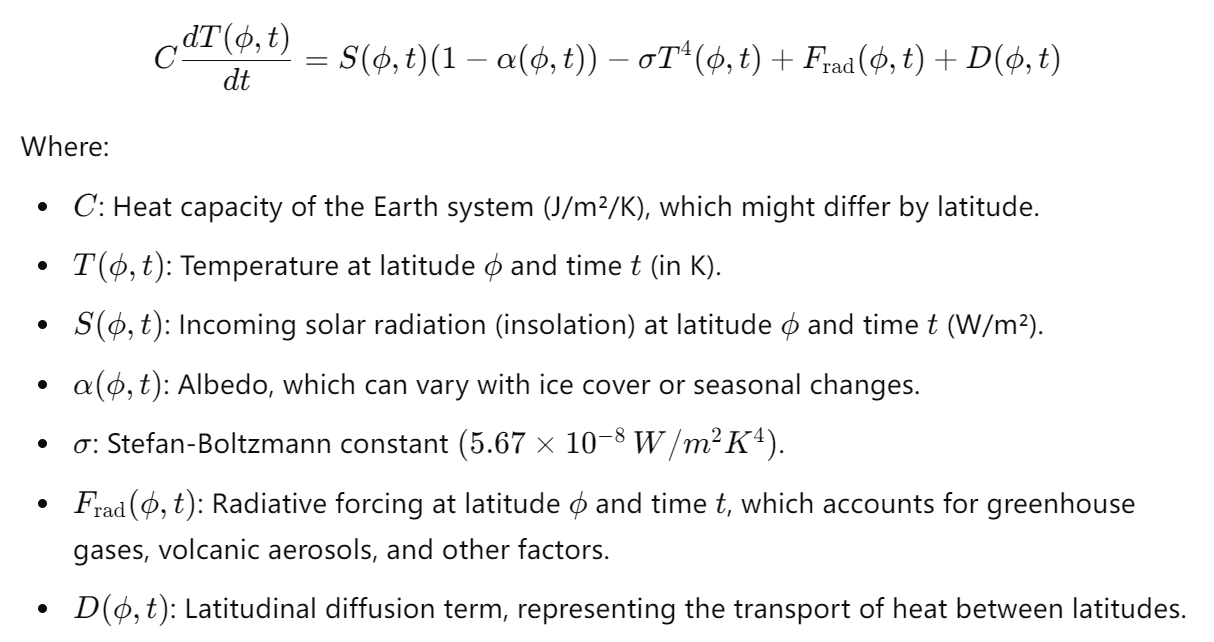

**Discretization**

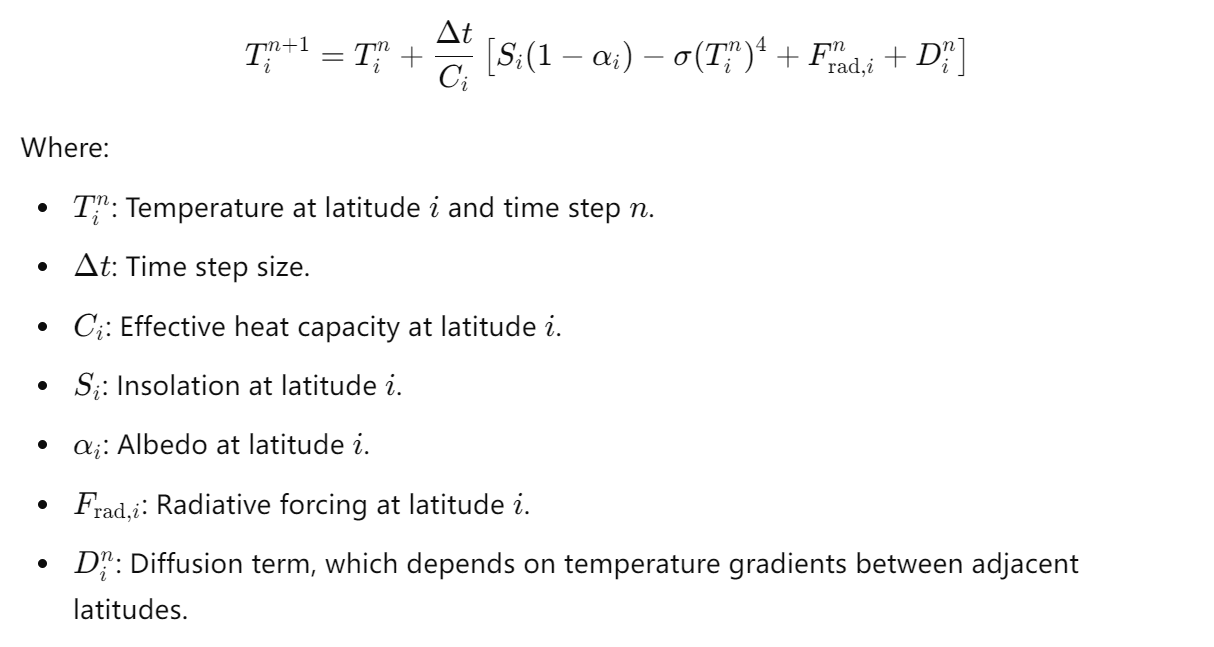

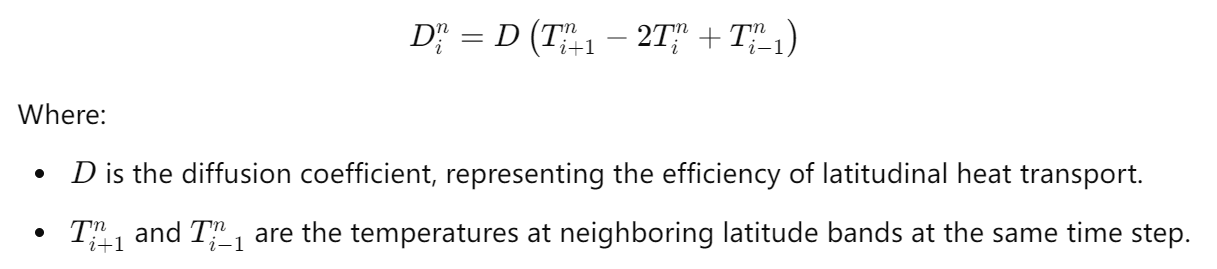

### Data preparation: Get familiar with Ice6G Data

In [70]:
import xarray as xr

file_path = 'D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.11.5.nc'  # Replace this with the correct path if necessary
dataset = xr.open_dataset(file_path)
sftgif_data = dataset['sftgif'].values

raw_80_90 = dataset['sftgif'].sel(lat=slice(80, 90)).mean(dim='lat').mean(dim='lon').values
raw_70_80 = dataset['sftgif'].sel(lat=slice(70, 80)).mean(dim='lat').mean(dim='lon').values

print(f"Raw data for 80-90°: {raw_80_90}")
print(f"Raw data for 70-80°: {raw_70_80}")

# sftgif_df = pd.DataFrame(sftgif_data, index=dataset['lat'].values, columns=dataset['lon'].values)

# print(dataset['lat'].values) 
# raw_values_80_90 = dataset['sftgif'].sel(lat=slice(80, 90)).values
# print(raw_values_80_90)
# print(sftgif_df.head(50)) 
# print(dataset['sftgif'].values)

Raw data for 80-90°: 8.146605491638184
Raw data for 70-80°: 27.8148136138916


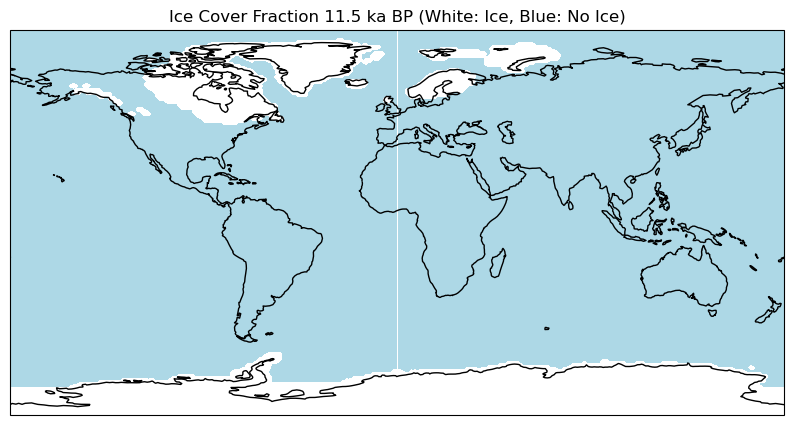

In [71]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap

colors = ['lightblue', 'white']
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ice_data = dataset['sftgif'].values
lat = dataset['lat'].values
lon = dataset['lon'].values

plt.contourf(lon, lat, ice_data, levels=[0, 1, 100], cmap=cmap, transform=ccrs.PlateCarree())

ax.coastlines()

plt.title('Ice Cover Fraction 11.5 ka BP (White: Ice, Blue: No Ice)')
plt.show()

### Put into a class

#### 1. Insolation
#### 2. Volcanic forcing

In [35]:
import xarray as xr
import pandas as pd
import csv
import math

class HoloceneEBM(EnergyBalanceModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.df_vol_Holocene = None
        self.df_ice_Holocene = None 
        self.df_ghg_Holocene = None
        self.df_temp = None
        self.iterations_Holocene = 12000
    
    def process_insolation_data(self):
        import pandas as pd
from scipy.interpolate import interp1d

class HoloceneEBM(EnergyBalanceModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.df_vol_Holocene = None
        self.df_ice_Holocene = None 
        self.df_ghg_Holocene = None
        self.iterations_Holocene = 12000  
        
        self.Zones = ["80-90", "70-80", "60-70", "50-60", "40-50", "30-40", "20-30", "10-20", "0-10"]
    
    def process_insolation_data(self):
        insolation_data = pd.read_csv(r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\Insolation_12kyr.csv")
        insolation_data.set_index('Time', inplace=True)
        
        latitudes = ['Lat_85', 'Lat_75', 'Lat_65', 'Lat_55', 'Lat_45', 'Lat_35', 'Lat_25', 'Lat_15', 'Lat_5']
        
        interpolated_data = insolation_data.reindex(range(0, self.iterations_Holocene + 1)).interpolate(method='linear')
        
        df_insolation = pd.DataFrame(columns=self.Zones)
        
        for year in range(self.iterations_Holocene + 1):
            insolation_row = interpolated_data.loc[year]

            R_in = [
                insolation_row['Lat_85'],  # Corresponding to Zone "80-90"
                insolation_row['Lat_75'],  # Corresponding to Zone "70-80"
                insolation_row['Lat_65'],  # Corresponding to Zone "60-70"
                insolation_row['Lat_55'],  # Corresponding to Zone "50-60"
                insolation_row['Lat_45'],  # Corresponding to Zone "40-50"
                insolation_row['Lat_35'],  # Corresponding to Zone "30-40"
                insolation_row['Lat_25'],  # Corresponding to Zone "20-30"
                insolation_row['Lat_15'],  # Corresponding to Zone "10-20"
                insolation_row['Lat_5']    # Corresponding to Zone "0-10"
            ]

            df_insolation.loc[year] = R_in
            
        self.df_insol_Holocene = df_insolation
        # print (self.df_insol_Holocene)
        return self.df_insol_Holocene


    def process_volcanic_data(self):
        dataset_saod = xr.open_dataset(r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\Sigl_2021_SAOD.nc")

        saod_bp = 1950 - dataset_saod['time'].values  # Convert AD time to BP
        saod_data = dataset_saod['aod550'].values     # SAOD data (time, latitude)
        latitudes = dataset_saod['lat'].values        # Latitude values

        df_vol_rf = pd.DataFrame(-25 * saod_data, index=saod_bp, columns=latitudes)
        df_vol_rf['Year'] = df_vol_rf.index.round().astype(int)
        df_vol_grouped = df_vol_rf.groupby('Year').mean()

        # Bin latitudes
        df_vol_binned = pd.DataFrame()
        for i, zone_label in enumerate(self.Zones):
            zone_cols = [col for col in df_vol_grouped.columns if self.ZoneLat[i]-5 <= col < self.ZoneLat[i]+5]
            if zone_cols:
                df_vol_binned[zone_label] = df_vol_grouped[zone_cols].mean(axis=1)

        
        self.df_vol_Holocene = df_vol_binned
        # print (self.df_vol_Holocene)  
        return self.df_vol_Holocene
    
holocene_ebm = HoloceneEBM()
holocene_ebm.process_volcanic_data()
holocene_ebm.process_insolation_data()

E:\Anaconda1\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


,80-90,70-80,60-70,50-60,40-50,30-40,20-30,10-20,0-10
0,174.282875,186.143740,214.310030,261.071673,307.847532,348.838274,381.384819,403.887061,415.371208
1,174.283765,186.144507,214.310424,261.071819,307.847548,348.838204,381.384688,403.886880,415.371023
2,174.284655,186.145275,214.310818,261.071964,307.847564,348.838134,381.384558,403.886700,415.370837
3,174.285545,186.146042,214.311212,261.072110,307.847580,348.838064,381.384427,403.886519,415.370652
4,174.286435,186.146810,214.311606,261.072256,307.847596,348.837994,381.384297,403.886338,415.370467
...,...,...,...,...,...,...,...,...,...
11996,179.211769,190.407593,216.560266,261.899174,307.939820,348.443754,380.657567,402.947151,414.328449
11997,179.211372,190.407248,216.560079,261.899107,307.939813,348.443788,380.657627,402.947228,414.328538
11998,179.210975,190.406904,216.559892,261.899039,307.939806,348.443823,380.657687,402.947305,414.328626
11999,179.210577,190.406559,216.559705,261.898972,307.939800,348.443857,380.657747,402.947382,414.328715


#### 3. Ice cover

In [40]:
import numpy as np
from scipy.interpolate import interp1d
import re
import math

def process_ice_cover_data(self):
    file_paths = [
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.0.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.0.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.1.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.1.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.2.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.2.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.3.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.3.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.4.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.4.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.5.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.6.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.6.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.7.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.7.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.8.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.8.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.9.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.9.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.10.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.10.5.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.11.nc",
        r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\I6_C.VM5a_1deg.11.5.nc"
    ]

    time_steps = []
    ice_cover_values = {zone: [] for zone in self.Zones}
    albedo_values = {zone: [] for zone in self.Zones}
    radiative_forcing_values = {zone: [] for zone in self.Zones}

    for file_path in file_paths:
        dataset = xr.open_dataset(file_path)
        ice_data = dataset['sftgif'] 

        # Extract the time step from the file name
        if time_step_match := re.search(r"(\d+\.\d+|\d+)(?=\.nc$)", file_path):
            time_step = float(time_step_match.group()) * 1000
            time_steps.append(time_step)

        # Process data for each latitude zone
        for i, zone_label in enumerate(self.Zones):
            lat_start = self.ZoneLat[i] - 5
            lat_end = self.ZoneLat[i] + 5

            # Select the ice fraction data for this latitude zone
            zone_ice_data = ice_data.sel(lat=slice(lat_start, lat_end))
            ice_cover_fraction = zone_ice_data.mean(dim='lat').mean(dim='lon').values / 100

            # Calculate albedo based on ice cover
            albedo = ice_cover_fraction * self.Aice + (1 - ice_cover_fraction) * self.Acloud

            # print(f"Time: {time_step}, Zone: {zone_label}, Fraction: {ice_cover_fraction}, Albedo: {albedo}")

            # Store the values for interpolation later
            ice_cover_values[zone_label].append(ice_cover_fraction)
            albedo_values[zone_label].append(albedo)

    # Interpolate to 1-year resolution after collecting all time steps
    all_years = np.arange(0, 12000, 1)  # 0 to 12 kyr, 1-year resolution
    interpolated_ice_cover = pd.DataFrame(index=all_years)
    interpolated_albedo = pd.DataFrame(index=all_years)

    # Loop over zones and interpolate values
    for zone_label in self.Zones:
        # Interpolate ice cover
        interp_ice_cover = interp1d(time_steps, ice_cover_values[zone_label], kind='linear', fill_value="extrapolate")
        interpolated_ice_cover[zone_label] = interp_ice_cover(all_years)

        # Interpolate albedo
        interp_albedo = interp1d(time_steps, albedo_values[zone_label], kind='linear', fill_value="extrapolate")
        interpolated_albedo[zone_label] = interp_albedo(all_years)

    # Combine the interpolated results into a single DataFrame
    df_ice = pd.concat([interpolated_ice_cover, interpolated_albedo], 
                       axis=1, 
                       keys=["Ice Cover Fraction", "Albedo"])

    self.df_ice_albedo_Holocene = df_ice
    # print(self.df_ice_albedo_Holocene)
    return self.df_ice_albedo_Holocene

HoloceneEBM.process_ice_cover_data = process_ice_cover_data
holocene_ebm = HoloceneEBM()
holocene_ebm.process_ice_cover_data()

Ice Cover Fraction                                                      \
                   80-90     70-80     60-70     50-60     40-50 30-40 20-30   
0               0.022994  0.108241  0.034599  0.002708  0.000000   0.0   0.0   
1               0.022994  0.108241  0.034599  0.002708  0.000000   0.0   0.0   
2               0.022994  0.108241  0.034599  0.002708  0.000000   0.0   0.0   
3               0.022994  0.108241  0.034599  0.002708  0.000000   0.0   0.0   
4               0.022994  0.108241  0.034599  0.002708  0.000000   0.0   0.0   
...                  ...       ...       ...       ...       ...   ...   ...   
11995           0.096347  0.356386  0.270248  0.132997  0.022961   0.0   0.0   
11996           0.096377  0.356544  0.270292  0.133015  0.022971   0.0   0.0   
11997           0.096407  0.356702  0.270337  0.133033  0.022980   0.0   0.0   
11998           0.096437  0.356860  0.270382  0.133051  0.022990   0.0   0.0   
11999           0.096467  0.357018  0.270426  0.133068  0.023000   0.0   0.0   

                    Albedo                                                \
      10-20 0-10     80-90     70-80     60-70     50-60     40-50 30-40   
0       0.0  0.0  0.307358  0.334637  0.311072  0.300867  0.300000   0.3   
1       0.0  0.0  0.307358  0.334637  0.311072  0.300867  0.300000   0.3   
2       0.0  0.0  0.307358  0.334637  0.311072  0.300867  0.300000   0.3   
3       0.0  0.0  0.307358  0.334637  0.311072  0.300867  0.300000   0.3   
4       0.0  0.0  0.307358  0.334637  0.311072  0.300867  0.300000   0.3   
...     ...  ...       ...       ...       ...       ...       ...   ...   
11995   0.0  0.0  0.330831  0.414043  0.386479  0.342559  0.307347   0.3   
11996   0.0  0.0  0.330841  0.414094  0.386494  0.342565  0.307351   0.3   
11997   0.0  0.0  0.330850  0.414145  0.386508  0.342570  0.307354   0.3   
11998   0.0  0.0  0.330860  0.414195  0.386522  0.342576  0.307357   0.3   
11999   0.0  0.0  0.330869  0.414246  0.386536  0.342582  0.307360   0.3   

                        
      20-30 10-20 0-10  
0       0.3   0.3  0.3  
1       0.3   0.3  0.3  
2       0.3   0.3  0.3  
3       0.3   0.3  0.3  
4       0.3   0.3  0.3  
...     ...   ...  ...  
11995   0.3   0.3  0.3  
11996   0.3   0.3  0.3  
11997   0.3   0.3  0.3  
11998   0.3   0.3  0.3  
11999   0.3   0.3  0.3  

[12000 rows x 18 columns]

#### 4. Greenhouse Gas 

In [37]:
import pandas as pd
import matplotlib.pyplot as plt



def process_ghg_data(self):
    def load_ghg_data(file_path, gas, start_line):
        data = pd.read_csv(file_path, sep='\t', skiprows=start_line, comment='/', names=['AGE [ka BP]', f'{gas} [nmol/mol]', f'dR_[{gas}]'])
        forcing = data[['AGE [ka BP]', f'dR_[{gas}]']].rename(columns={'AGE [ka BP]': 'Year', f'dR_[{gas}]': f'{gas}_RF'})
        forcing['Year'] *= 1000 
        forcing = forcing[forcing['Year'] <= 12000]  
        return forcing.set_index('Year').sort_index()

    co2_file_path = r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\CO2_stack_156K_spline_V1.tab"
    ch4_file_path = r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\CH4_stack_156K_spline_V1.tab"
    n2o_file_path = r"D:\OneDrive - University of Cambridge\Tripos\Projects\Holocene EBM\N2O_stack_134K_spline_V1.tab"
    
    co2_forcing = load_ghg_data(co2_file_path, 'CO2', 15)
    ch4_forcing = load_ghg_data(ch4_file_path, 'CH4', 15)
    n2o_forcing = load_ghg_data(n2o_file_path, 'N2O', 18)

    ghg_forcing = co2_forcing.merge(ch4_forcing, left_index=True, right_index=True).merge(n2o_forcing, left_index=True, right_index=True)
    ghg_forcing['Total_RF'] = ghg_forcing['CO2_RF'] + ghg_forcing['CH4_RF'] + ghg_forcing['N2O_RF']
    ghg_forcing_dict = ghg_forcing.set_index(ghg_forcing.index)['Total_RF'].to_dict()

    years = np.arange(0, 12000)    
    interpolated_ghg_forcing = pd.DataFrame(index=years, columns=self.Zones)
    
    for zone, lat in zip(self.Zones, self.ZoneLat):
            interpolated_ghg_forcing[zone] = pd.Series(ghg_forcing_dict).interpolate()

    self.df_ghg_Holocene = interpolated_ghg_forcing
    # pd.set_option('display.max_rows', None)
    # print (self.df_ghg_Holocene)  
    return (self.df_ghg_Holocene)

HoloceneEBM.process_ghg_data = lambda self: process_ghg_data(self)
# holocene_ebm = HoloceneEBM()
holocene_ebm.process_ghg_data()

,80-90,70-80,60-70,50-60,40-50,30-40,20-30,10-20,0-10
0,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
1,0.970,0.970,0.970,0.970,0.970,0.970,0.970,0.970,0.970
2,0.961,0.961,0.961,0.961,0.961,0.961,0.961,0.961,0.961
3,0.954,0.954,0.954,0.954,0.954,0.954,0.954,0.954,0.954
4,0.950,0.950,0.950,0.950,0.950,0.950,0.950,0.950,0.950
...,...,...,...,...,...,...,...,...,...
11995,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976
11996,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976
11997,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977
11998,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978


### Run Simulation

In [41]:
import pandas as pd
import numpy as np

def run_simulation_with_forcings(self):
    # Volcano data is available from 50-14950 kyr bp
    self.df_vol_Holocene = self.df_vol_Holocene.reindex(range(self.iterations_Holocene), fill_value=0)
    # Ghg data has some missing values
    self.df_ghg_Holocene.interpolate(method='linear', inplace=True)

    # Constants
    self.dt = 1      # Time step in years
    self.HC = 2.1e7  # Global average heat capacity (J/m²/K)
    self.D = 0.7     # Diffusion coefficient (W/m²/K)
    sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m²K⁴)
    
    # Initialize the temperature array
    self.Temp = np.zeros((self.iterations_Holocene + 1, 9))  # 9 latitude zones
    
    # Dictionary for latitude zones
    lat_dic = {
        "1": "80-90",
        "2": "70-80",
        "3": "60-70",
        "4": "50-60",
        "5": "40-50",
        "6": "30-40",
        "7": "20-30",
        "8": "10-20",
        "9": "0-10",
    }
    
    # Set initial temperatures (initialize to some reasonable starting state)
    temp_step = self.Init_T[:]
    self.Temp[0] = temp_step[:]  # Store the initial temperature in the first row
    
    # Simulation over time steps
    for step in range(1, self.iterations_Holocene + 1):
        for lat in range(9):
            lat_label = lat_dic[str(lat + 1)]
    
            # retrive the data for each timestep
            insol = self.df_insol_Holocene.loc[self.iterations_Holocene - step, lat_label]  
            albedo = self.df_ice_albedo_Holocene.loc[self.iterations_Holocene - step, ('Albedo', lat_label)]  
            vol = self.df_vol_Holocene.loc[self.iterations_Holocene - step, lat_label]  
            ghg = self.df_ghg_Holocene.loc[self.iterations_Holocene - step, lat_label]  
            
            # Current temperature at this latitude
            T_lat = temp_step[lat]
    
            # Radiative forcing and albedo effects
            incoming_radiation = insol * (1 - albedo)
            radiative_forcing = vol + ghg
    
            # # Diffusion term
            # if lat > 0 and lat < 8:
            #     diffusion_term = self.D * (temp_step[lat + 1] - 2 * T_lat + temp_step[lat - 1])
            # elif lat == 0:
            #     diffusion_term = self.D * (temp_step[lat + 1] - T_lat)  # No previous latitude
            # else:
            #     diffusion_term = self.D * (temp_step[lat - 1] - T_lat)  # No next latitude
    
            # Update temperature for the next time step using the transient energy balance equation
            # temp_step[lat] = temp_step[lat] + (self.dt / self.HC) * (
            #     incoming_radiation + radiative_forcing - sigma * T_lat**4 + diffusion_term
            # )
            temp_step[lat] = temp_step[lat] + (self.dt / self.HC) * (
                incoming_radiation + radiative_forcing - sigma * T_lat**4
            )
    
        # Store the temperatures of the current time step in the 2D array
        self.Temp[step] = temp_step[:]  # Each row is the temperature for this time step

        # # Debug
        # if self.iterations_Holocene - step == 8191:
        #     print(f"Step {step}, year {self.iterations_Holocene - step}, Latitude {lat_label}")
        #     print(f"Insolation: {self.df_insol_Holocene.loc[self.iterations_Holocene - step, lat_label]}")
        #     print(f"Albedo: {self.df_ice_albedo_Holocene.loc[self.iterations_Holocene - step, ('Albedo', lat_label)]}")
        #     print(f"Volcanic Forcing: {self.df_vol_Holocene.loc[self.iterations_Holocene - step, lat_label]}")
        #     print(f"GHG Forcing: {self.df_ghg_Holocene.loc[self.iterations_Holocene - step, lat_label]}")
    
    # Convert time steps to years BP (assuming step 0 is present, e.g., 0 BP, and time is counted back)
    years_bp = np.arange(0, self.iterations_Holocene + 1) 
    years_bp = 12000 - years_bp 
    
    # Create DataFrame for temperature (rows: years BP, columns: latitude zones)
    self.df_temp = pd.DataFrame(self.Temp, columns=self.ZoneLat, index=years_bp)
    
    # # Check for missing data in final DataFrame
    # print("Checking for NaN values in df_temp...")
    # print(self.df_temp.isna().sum())
    # pd.reset_option('display.max_rows')

    return self.df_temp  



HoloceneEBM.run_simulation_with_forcings = lambda self: run_simulation_with_forcings(self)

pd.reset_option('display.max_rows') 
holocene_ebm.process_insolation_data()
holocene_ebm.process_volcanic_data()
HoloceneEBM.process_ice_cover_data = lambda self: process_ice_cover_data(self)
holocene_ebm.process_ice_cover_data()
HoloceneEBM.process_ghg_data = lambda self: process_ghg_data(self)
holocene_ebm.process_ghg_data()
holocene_ebm.run_simulation_with_forcings()
df_temp = holocene_ebm.run_simulation_with_forcings()                                                                                                                                                                               
print(df_temp)

              85         75        65        55        45         35  \
12000 -16.900000 -12.300000 -5.100000  2.200000  8.800000  16.200000   
11999 -16.899994 -12.299995 -5.099994  2.200008  8.800010  16.200012   
11998 -16.899989 -12.299989 -5.099987  2.200016  8.800020  16.200023   
11997 -16.899983 -12.299984 -5.099981  2.200024  8.800030  16.200035   
11996 -16.899977 -12.299979 -5.099975  2.200033  8.800040  16.200046   
...          ...        ...       ...       ...       ...        ...   
4     -16.830418 -12.229392 -5.017395  2.302473  8.922507  16.338904   
3     -16.830412 -12.229386 -5.017388  2.302482  8.922517  16.338916   
2     -16.830406 -12.229380 -5.017381  2.302491  8.922527  16.338927   
1     -16.830400 -12.229374 -5.017374  2.302499  8.922538  16.338939   
0     -16.830394 -12.229368 -5.017367  2.302508  8.922548  16.338951   

              25         15         5   
12000  22.900000  26.100000  26.400000  
11999  22.900013  26.100013  26.400014  
11998  22.90

In [42]:
import pandas as pd
import numpy as np

def run_simulation_with_forcings(self):
    self.df_vol_Holocene = self.df_vol_Holocene.reindex(range(self.iterations_Holocene), fill_value=0)
    self.df_ghg_Holocene.interpolate(method='linear', inplace=True)

    self.dt = 1      # Time step in years
    self.HC = 2.1e7  # Global average heat capacity (J/m²/K)
    self.D = 0.7     # Diffusion coefficient (W/m²/K)
    sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m²K⁴)
    
    self.Temp = np.zeros((self.iterations_Holocene + 1, 9))  # 9 latitude zones
    
    lat_dic = {
        "1": "80-90",
        "2": "70-80",
        "3": "60-70",
        "4": "50-60",
        "5": "40-50",
        "6": "30-40",
        "7": "20-30",
        "8": "10-20",
        "9": "0-10",
    }
    
    temp_step = np.array(self.Init_T) + 273.15
    self.Temp[0] = temp_step[:]  # Store the initial temperature in the first row

    target_lat = 2  # Corresponds to "60-70" band

    iterations = self.iterations_Holocene
    terms_data = {
        'incoming_radiation': [],
        'radiative_forcing': [],
        'outgoing_radiation': [],
        'diffusion': [],
        'delta_T': [],
        'T': []
    }

    for step in range(1, iterations + 1):
        for lat in range(9):
            lat_label = lat_dic[str(lat + 1)]
    
            insol = self.df_insol_Holocene.loc[iterations - step, lat_label]  
            albedo = self.df_ice_albedo_Holocene.loc[iterations - step, ('Albedo', lat_label)]  
            vol = self.df_vol_Holocene.loc[iterations - step, lat_label]  
            ghg = self.df_ghg_Holocene.loc[iterations - step, lat_label]  
            
            T_lat = temp_step[lat]
    
            incoming_radiation = insol * (1 - albedo)
            radiative_forcing = vol + ghg
            outgoing_radiation = sigma * T_lat**4

            if lat > 0 and lat < 8:
                diffusion_term = self.D * (temp_step[lat + 1] - 2 * T_lat + temp_step[lat - 1])
            elif lat == 0:
                diffusion_term = self.D * (temp_step[lat + 1] - T_lat)  # No previous latitude
            else:
                diffusion_term = self.D * (temp_step[lat - 1] - T_lat)  # No next latitude

            # Total change in temperature
            delta_T = (self.dt / self.HC) * (
                incoming_radiation + radiative_forcing - outgoing_radiation + diffusion_term
            )

            # Update temperature for the next time step
            temp_step[lat] = temp_step[lat] + delta_T

            # If this is the target latitude, store the terms
            if lat == target_lat:
                terms_data['incoming_radiation'].append(incoming_radiation)
                terms_data['radiative_forcing'].append(radiative_forcing)
                terms_data['outgoing_radiation'].append(outgoing_radiation)
                terms_data['diffusion'].append(diffusion_term)
                terms_data['delta_T'].append(delta_T)
                terms_data['T'].append(temp_step[lat])

        # Store the temperatures of the current time step in the 2D array
        self.Temp[step] = temp_step[:]  # Each row is the temperature for this time step

    # Convert time steps to years BP (assuming step 0 is present, e.g., 0 BP, and time is counted back)
    years_bp = np.arange(1, iterations + 1)
    years_bp = 12000 - years_bp  # Adjust based on your timeline

    # Create DataFrame for the target latitude
    df_terms = pd.DataFrame(terms_data, index=years_bp)

    # Save the DataFrame to CSV
    df_terms.to_csv('terms_at_65_degrees.csv')

    # Optionally, create DataFrame for temperature across all latitudes
    self.df_temp = pd.DataFrame(self.Temp, columns=self.ZoneLat, index=np.arange(0, iterations + 1))
    self.df_temp.index = 12000 - self.df_temp.index  # Adjust the index to years BP

    return self.df_temp

HoloceneEBM.run_simulation_with_forcings = lambda self: run_simulation_with_forcings(self)

pd.reset_option('display.max_rows') 
holocene_ebm.process_insolation_data()
holocene_ebm.process_volcanic_data()
holocene_ebm.process_ice_cover_data()
holocene_ebm.process_ghg_data()
holocene_ebm.run_simulation_with_forcings()
df_temp = holocene_ebm.run_simulation_with_forcings()                                                                                                                                                                               
print(df_temp)

               85          75          65          55          45          35  \
12000  256.250000  260.850000  268.050000  275.350000  281.950000  289.350000   
11999  256.249994  260.849993  268.049992  275.349993  281.949993  289.349993   
11998  256.249988  260.849986  268.049985  275.349985  281.949986  289.349985   
11997  256.249983  260.849979  268.049977  275.349978  281.949979  289.349978   
11996  256.249977  260.849971  268.049969  275.349970  281.949972  289.349970   
...           ...         ...         ...         ...         ...         ...   
4      256.181842  260.771783  267.965543  275.266125  281.868258  289.261729   
3      256.181836  260.771777  267.965537  275.266119  281.868251  289.261722   
2      256.181831  260.771771  267.965530  275.266112  281.868244  289.261714   
1      256.181825  260.771764  267.965523  275.266105  281.868238  289.261707   
0      256.181819  260.771758  267.965516  275.266098  281.868231  289.261700   

               25          

### Visualizing the Results

In [38]:
holocene_ebm = HoloceneEBM()

holocene_ebm.process_insolation_data()
holocene_ebm.process_volcanic_data()
HoloceneEBM.process_ice_cover_data = lambda self: process_ice_cover_data(self)
holocene_ebm.process_ice_cover_data()
HoloceneEBM.process_ghg_data = lambda self: process_ghg_data(self)
holocene_ebm.process_ghg_data()

,80-90,70-80,60-70,50-60,40-50,30-40,20-30,10-20,0-10
0,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
1,0.970,0.970,0.970,0.970,0.970,0.970,0.970,0.970,0.970
2,0.961,0.961,0.961,0.961,0.961,0.961,0.961,0.961,0.961
3,0.954,0.954,0.954,0.954,0.954,0.954,0.954,0.954,0.954
4,0.950,0.950,0.950,0.950,0.950,0.950,0.950,0.950,0.950
...,...,...,...,...,...,...,...,...,...
11995,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976
11996,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976,-0.976
11997,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977,-0.977
11998,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978,-0.978


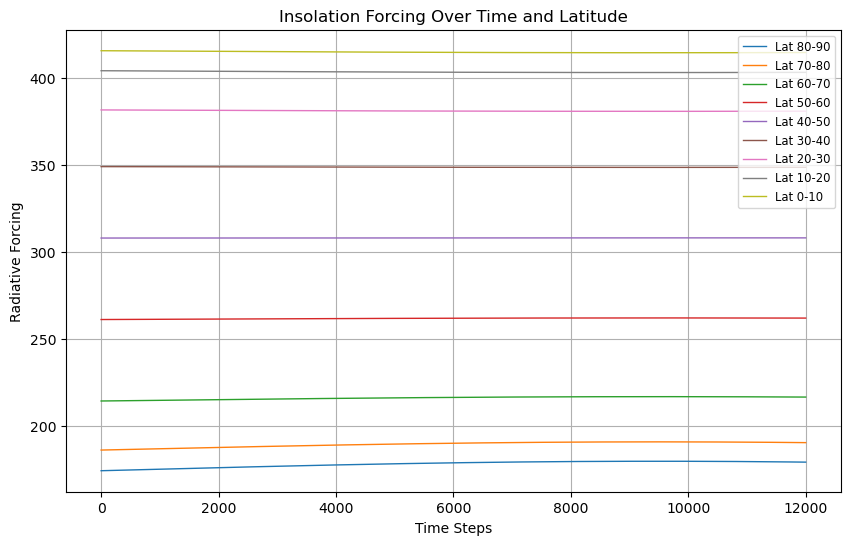

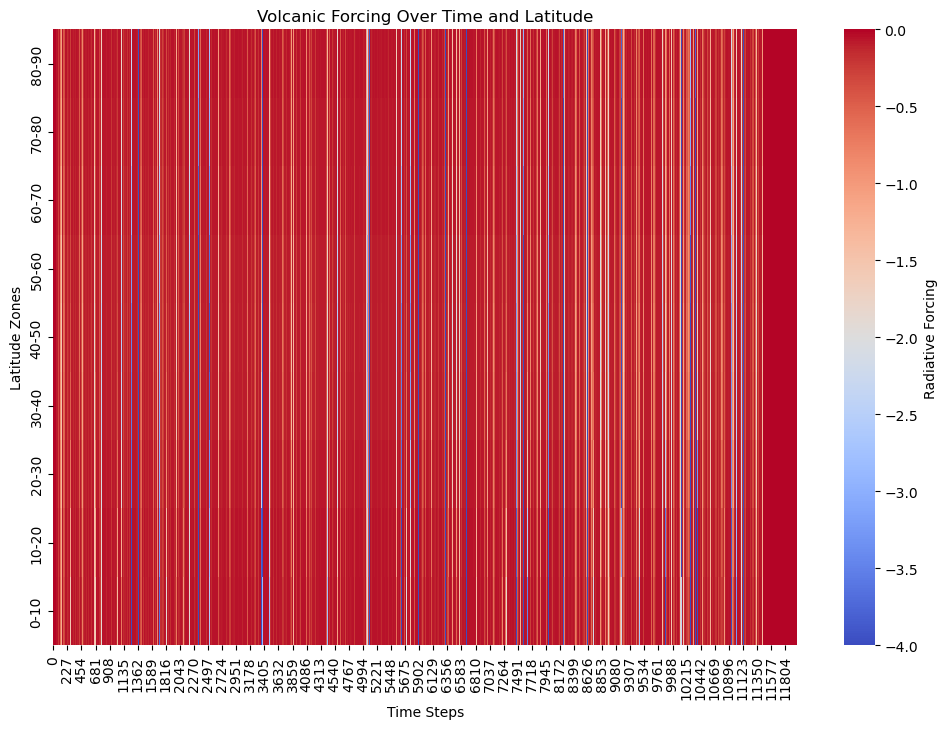

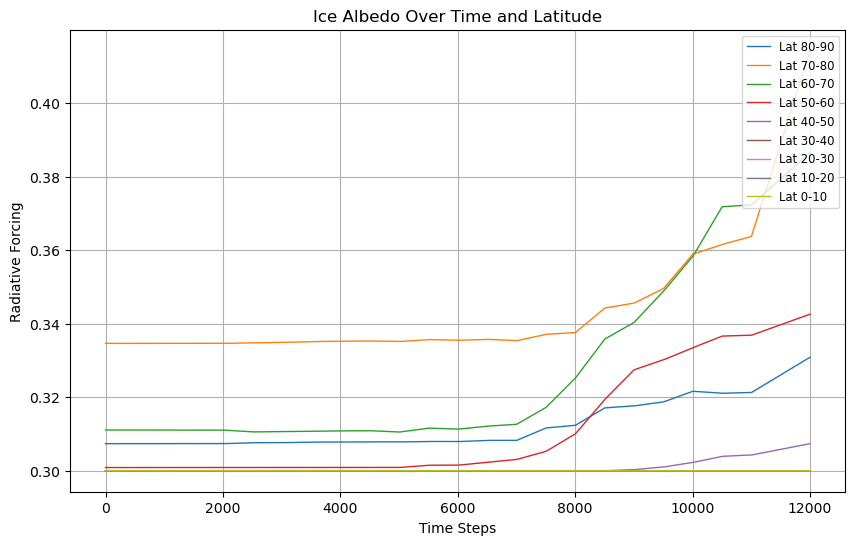

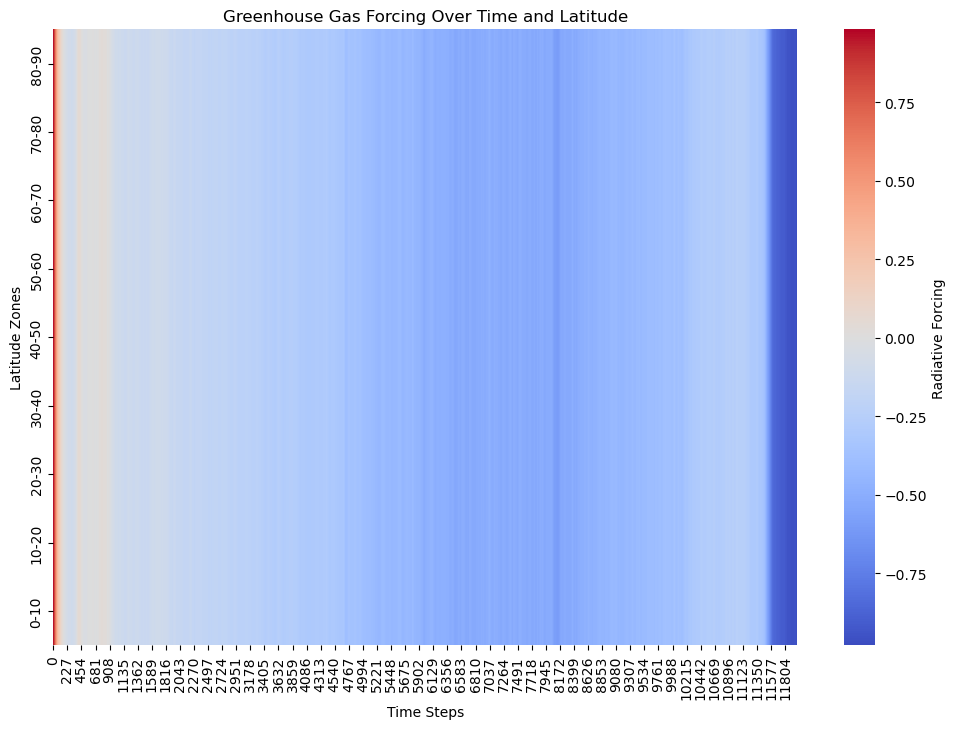

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_forcing_data(df, title, plot_type="heatmap", vmin=None, vmax=None):
    """
    Visualize radiative forcing data either as a heatmap or as a line plot for each latitude zone.

    Args:
    - df: Pandas DataFrame containing the forcing data (with time as index and latitudes as columns).
    - title: String for the plot title.
    - plot_type: 'heatmap' for heatmap visualization or 'line' for line plot for each latitude.
    - vmin: Minimum value for color scale (used for heatmap).
    - vmax: Maximum value for color scale (used for heatmap).
    """
    if plot_type == "heatmap":
        # Transpose the dataframe for correct orientation (latitudes on the Y-axis)
        df_transposed = df.T

        plt.figure(figsize=(12, 8))
        sns.heatmap(df_transposed, cmap="coolwarm", cbar_kws={'label': 'Radiative Forcing'},
                    vmin=vmin, vmax=vmax)  # Custom limits for color bar
        
        plt.title(title)
        plt.xlabel("Time Steps")
        plt.ylabel("Latitude Zones")
        plt.show()
    
    elif plot_type == "line":
        # Line plot for each latitude zone
        plt.figure(figsize=(10, 6))
        
        latitudes = df.columns  # Extract the latitude zones from the dataframe
        for lat in latitudes:
            plt.plot(df.index, df[lat], label=f'Lat {lat}', linewidth=1)  # Plot each latitude zone

        plt.title(title)
        plt.xlabel("Time Steps")
        plt.ylabel("Radiative Forcing")
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True)
        plt.show()
    else:
        print(f"Invalid plot_type '{plot_type}' provided. Use 'heatmap' or 'line'.")

visualize_forcing_data(holocene_ebm.df_insol_Holocene, "Insolation Forcing Over Time and Latitude", plot_type="line")
visualize_forcing_data(holocene_ebm.df_vol_Holocene, "Volcanic Forcing Over Time and Latitude", plot_type="heatmap", vmin=-4, vmax=0)
visualize_forcing_data(holocene_ebm.df_ice_albedo_Holocene.xs('Albedo', axis=1, level=0), "Ice Albedo Over Time and Latitude", plot_type="line")
visualize_forcing_data(holocene_ebm.df_ghg_Holocene, "Greenhouse Gas Forcing Over Time and Latitude", plot_type="heatmap")

# visualize_forcing_data(holocene_ebm.df_temp, "Temperature Over Time and Latitude", plot_type="heatmap")

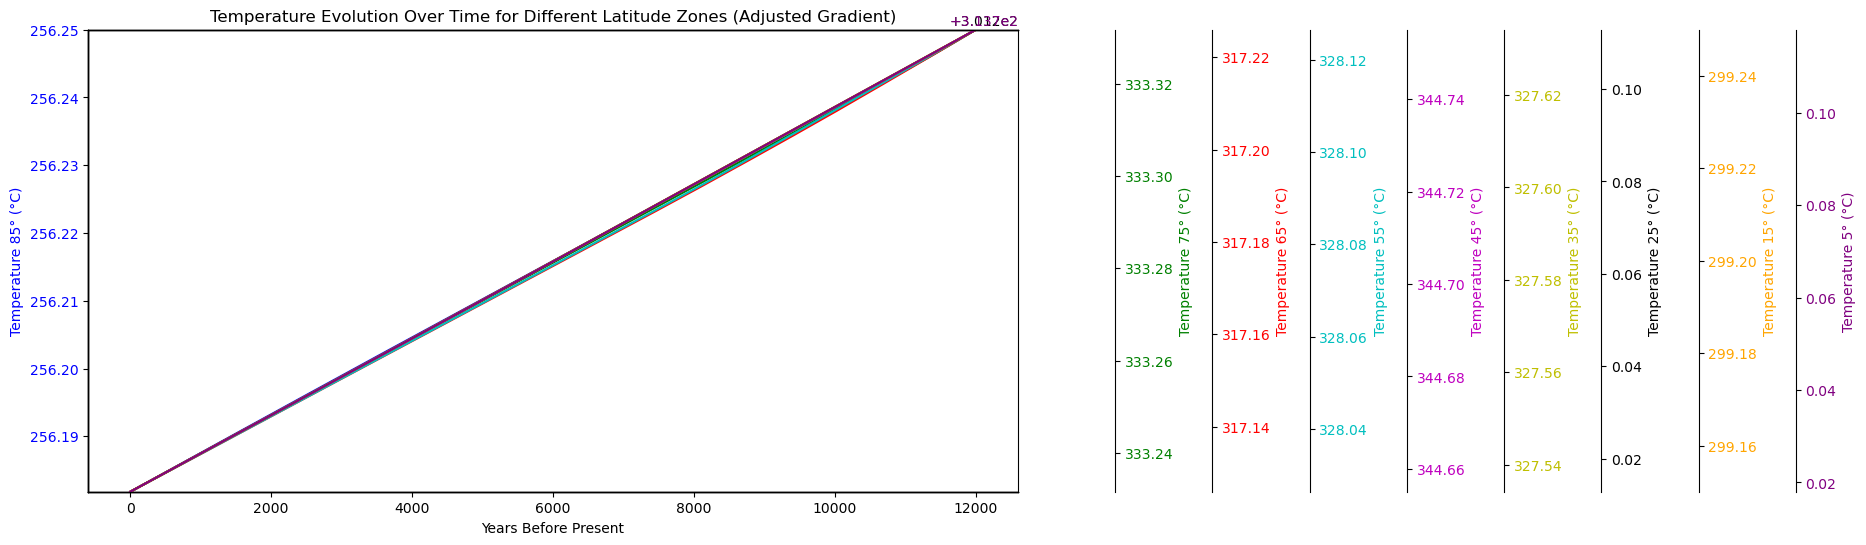

In [44]:
import matplotlib.pyplot as plt

def visualize_temp_data(self):
    # Create a figure and axis for the common x-axis (time)
    fig, host = plt.subplots(figsize=(12, 6))

    # Define the colors for each latitude zone line
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

    # Store the twin axes for each latitude zone
    axes = [host]

    # Get the temperature ranges for each latitude zone
    ranges = {zone: self.df_temp[zone].max() - self.df_temp[zone].min() for zone in self.ZoneLat}

    # Find the maximum temperature range to serve as the reference for the steepest gradient
    max_range = max(ranges.values())

    # Plot the first latitude zone (80-90) on the primary y-axis with its actual range
    zone = self.ZoneLat[0]
    host.plot(self.df_temp.index, self.df_temp[zone], color=colors[0], label=f'{zone}°')
    host.set_ylabel(f'Temperature {zone}° (°C)', color=colors[0])
    host.tick_params(axis='y', labelcolor=colors[0])

    # Set the limits for the y-axis to reflect the true temperature range of the first zone
    host.set_ylim(self.df_temp[zone].min(), self.df_temp[zone].max())

    # Adjust displacement between axes
    displacement = 70  # Space between y-axes

    # Loop over the remaining latitude zones and add them as twin axes
    for i, zone in enumerate(self.ZoneLat[1:], 1):
        ax_new = host.twinx()  # Create a new y-axis
        axes.append(ax_new)

        # Offset the position of the new y-axis to avoid overlapping
        ax_new.spines['right'].set_position(('outward', displacement * i))  # Adjust displacement

        # Scale the y-axis based on the temperature range compared to the largest range (for gradient adjustment)
        scale_factor = max_range / ranges[zone]

        # Plot the temperature evolution for the latitude zone, adjusting the gradient visually
        ax_new.plot(self.df_temp.index, self.df_temp[zone] * scale_factor, color=colors[i], label=f'{zone}°')

        # Set the axis labels and colors
        ax_new.set_ylabel(f'Temperature {zone}° (°C)', color=colors[i])
        ax_new.tick_params(axis='y', labelcolor=colors[i])

        # Set the y-axis limits proportionally to reflect the temperature range
        ax_new.set_ylim(self.df_temp[zone].min() * scale_factor, self.df_temp[zone].max() * scale_factor)

    # Set the common x-axis label
    host.set_xlabel('Years Before Present')

    # Title for the plot
    plt.title('Temperature Evolution Over Time for Different Latitude Zones (Adjusted Gradient)')


    # Show the plot
    plt.show()

HoloceneEBM.visualize_temp_data = lambda self: visualize_temp_data(self)

# Call the plotting function after running the simulation
holocene_ebm.visualize_temp_data()


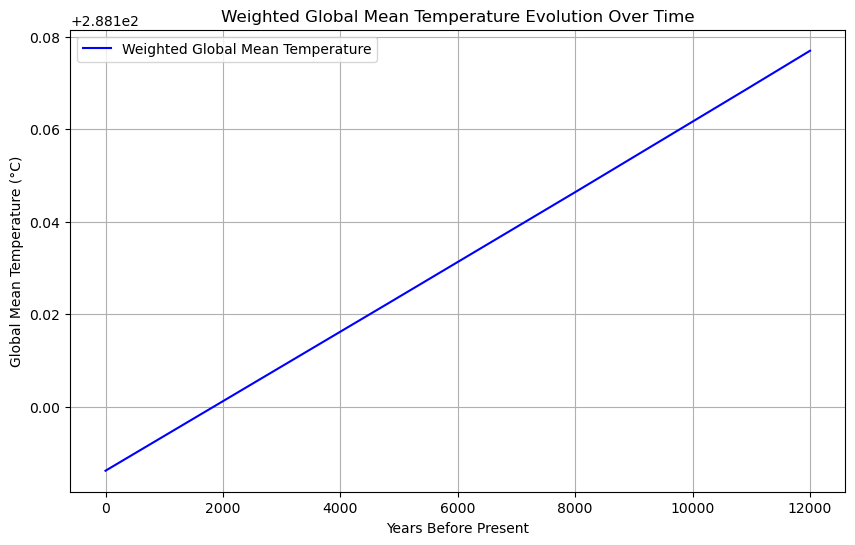

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def plot_global_mean_temperature(self):
    latitude_midpoints = np.array([85, 75, 65, 55, 45, 35, 25, 15, 5])  # Mid-points of the latitude zones

    cosine_weights = np.cos(np.radians(latitude_midpoints))
    global_mean_temp = (self.df_temp * cosine_weights).sum(axis=1) / cosine_weights.sum()

    plt.figure(figsize=(10, 6))
    plt.plot(self.df_temp.index, global_mean_temp, label='Weighted Global Mean Temperature', color='b')

    plt.xlabel('Years Before Present')
    plt.ylabel('Global Mean Temperature (°C)')
    plt.title('Weighted Global Mean Temperature Evolution Over Time')
    plt.grid(True)
    plt.legend()

    plt.show()

HoloceneEBM.plot_global_mean_temperature = lambda self: plot_global_mean_temperature(self)
holocene_ebm.plot_global_mean_temperature()